In [1]:
# we want to load in a pretrained resnet model.
# we want to use the ImageFolder format specified by PyTorch
# we freeze the resnet parameters and train on our new dataset.
# train and evaluate

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob
import itertools
from PIL import Image
from PIL.Image import BILINEAR
from torchinfo import summary
from transformers import (
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    EfficientNetConfig,
    EfficientNetForImageClassification,
    ViTForImageClassification,
    AutoTokenizer,
    EfficientNetImageProcessor,
    ViTImageProcessor,
)
import peft
import evaluate
import accelerate
import cv2


cudnn.benchmark = True
plt.ion()   # interactive mode

In [48]:
# For straightforward datasets, sometimes you can make do with built-in PyTorch dataset objects.
# We want to apply automated data augmentations, which will be different for the training
# and eval scenarios

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}

In [49]:
data_dir = "../../data/dataset/"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

class_names = image_datasets['train'].classes

print(class_names)

print(image_datasets.keys())
print("label", image_datasets['train'][0][1])
# we will use this test image to do all our preliminary testing to make sure stuff works.
test_image = image_datasets['train'][0][0]
test_image = test_image.unsqueeze(0)
test_image.mean(), test_image.std(), test_image.shape

['1', '2', '3', '4', '5']
dict_keys(['train', 'val'])
label 0


(tensor(0.3929), tensor(0.2438), torch.Size([1, 3, 224, 224]))

In [5]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x[0] for x in batch]),
        "labels": torch.LongTensor([int(x[1]) for x in batch]),
    }

## Load ViT Model

In [50]:
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=5,
    ignore_mismatched_sizes=True,
    output_attentions = True
)
vit, "num param", sum(p.numel() for p in vit.parameters())

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(ViTForImageClassification(
   (vit): ViTModel(
     (embeddings): ViTEmbeddings(
       (patch_embeddings): ViTPatchEmbeddings(
         (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
       )
       (dropout): Dropout(p=0.0, inplace=False)
     )
     (encoder): ViTEncoder(
       (layer): ModuleList(
         (0-11): 12 x ViTLayer(
           (attention): ViTAttention(
             (attention): ViTSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.0, inplace=False)
             )
             (output): ViTSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.0, inplace=False)
             )
           )
           (intermediate): ViTIntermediate(
             (den

In [52]:
inputs = image_processor(images = test_image, return_tensors = 'pt')

print(inputs.keys())

output = vit(**inputs)





dict_keys(['pixel_values'])


In [53]:
print(len(output.attentions))
print(type(output.attentions))
attention_matrices = [output.attentions[i] for i in range(len(output.attentions))]

attention_matrices = torch.stack([output.attentions[i] for i in range(len(output.attentions))])
attention_matrices = attention_matrices.squeeze(1)
print(attention_matrices.shape)


12
<class 'tuple'>
torch.Size([12, 12, 197, 197])


In [54]:
att_mat = attention_matrices
att_mat = torch.mean(att_mat, dim=1) #taking average of attention across all heads
print("shape of att_mat after averaging", att_mat.shape)
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
print("residual att size", att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

print("aug_att_mat shape", aug_att_mat.shape)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]
print("joint attentions shape:", joint_attentions.shape)

print("shape of augmented attention matrix:", aug_att_mat.size(0))
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

print(joint_attentions[0])
# Attention from the output token to the input space.
v = joint_attentions[-1]

print("values of v", v)
print("shape of v", v.shape)
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
print("grid size", grid_size)
attention_map = mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), (224,224))[..., np.newaxis]
mask = np.repeat(mask, 3, axis=-1)  # Replicate mask across channels
mask = np.transpose(mask, (2, 0, 1))  # Transpose mask to match the order of dimensions in test_image

print("mask shape", mask.shape)
#result = (mask * test_image.squeeze(0).numpy()).astype("uint8")

#print(result[0])




shape of att_mat after averaging torch.Size([12, 197, 197])
residual att size 197
aug_att_mat shape torch.Size([12, 197, 197])
joint attentions shape: torch.Size([12, 197, 197])
shape of augmented attention matrix: 12
tensor([[0.8279, 0.0014, 0.0012,  ..., 0.0011, 0.0012, 0.0014],
        [0.1000, 0.5470, 0.0055,  ..., 0.0015, 0.0015, 0.0016],
        [0.0984, 0.0052, 0.5468,  ..., 0.0014, 0.0014, 0.0017],
        ...,
        [0.0985, 0.0016, 0.0014,  ..., 0.5459, 0.0043, 0.0048],
        [0.0996, 0.0016, 0.0013,  ..., 0.0043, 0.5462, 0.0051],
        [0.1010, 0.0016, 0.0015,  ..., 0.0044, 0.0048, 0.5469]],
       grad_fn=<SelectBackward0>)
values of v tensor([[0.2431, 0.0073, 0.0054,  ..., 0.0044, 0.0051, 0.0067],
        [0.2416, 0.0076, 0.0055,  ..., 0.0044, 0.0051, 0.0067],
        [0.2414, 0.0073, 0.0057,  ..., 0.0044, 0.0051, 0.0067],
        ...,
        [0.2414, 0.0072, 0.0054,  ..., 0.0047, 0.0051, 0.0067],
        [0.2415, 0.0072, 0.0054,  ..., 0.0045, 0.0054, 0.0068],
     

(224, 224)


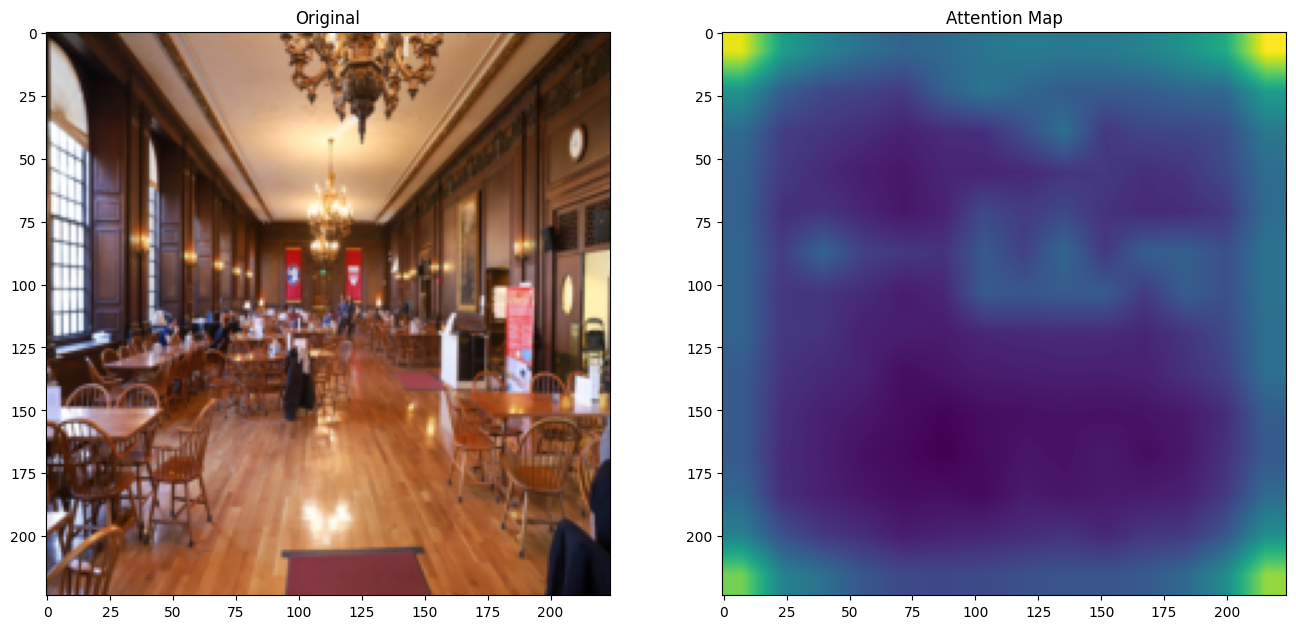

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
print(mask[0].shape)
ax1.set_title('Original')
ax2.set_title('Attention Map')
ax1.imshow(test_image.squeeze(0).permute(1, 2, 0))
ax2.imshow(mask[0], cmap="viridis")

## LoRa FineTuning for ViT

In [11]:
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
model = get_peft_model(vit, config)
model.print_trainable_parameters()

trainable params: 593,669 || all params: 86,396,170 || trainable%: 0.6871473584998039


## LIME Tool

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=5,
    ignore_mismatched_sizes=True
)

# Load an example image
example_image = Image.open("../../data/dataset/train/1/File 00008.jpg")
inputs = image_processor(images = example_image, return_tensors = 'pt')
example_tensor = inputs['pixel_values'].squeeze(0)

print("shape of image", example_tensor.numpy().shape)
# Get the model prediction for the example image
model_output = vit(example_tensor.unsqueeze(0))
print(model_output)
predicted_class = torch.argmax(model_output.logits)

# Create an instance of the LIME explainer
explainer = lime_image.LimeImageExplainer()

def model_predict(inputs):
    # Convert the inputs to a PyTorch tensor
    if inputs.ndim == 3:
        inputs = inputs.unsqueeze(0)  # add a batch dimension if it doesn't exist.
    print("inputs shape", inputs.shape)  # (B, H, W, C)
    inputs = torch.from_numpy(inputs).permute(0, 3, 1, 2).float()

    # Get the model's output logits
    with torch.no_grad():
        logits = vit(inputs).logits

    # Convert the logits to probabilities
    probs = torch.softmax(logits, dim=1)

    # Return the probabilities as a NumPy array
    return probs.cpu().numpy()

# Explain the prediction
explanation = explainer.explain_instance(np.transpose(example_tensor.numpy(), (1, 2, 0)), model_predict, top_labels=5, hide_color=0, num_samples=1000)

# Get the explanation for the predicted class
idx_predicted_class = list(explanation.top_labels).index(predicted_class.item())
temp, mask = explanation.get_image_and_mask(idx_predicted_class, positive_only=True, num_features=5, hide_rest=False)

# Display the explanation
print("temp shape:", temp.shape)
print("mask shape", mask.shape)
mask_grayscale = np.mean(mask, axis = -1).astype(np.int32)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.imshow(mark_boundaries(temp, mask_grayscale))
ax2.imshow(mask)
plt.show()

## SHAP

In [56]:
import shap



In [57]:
X, y = shap.datasets.imagenet50()
print(X[1:3].shape, X[0].shape)
print(type(X[1,3]))

(2, 224, 224, 3) (224, 224, 3)
<class 'numpy.ndarray'>


In [58]:
##SHAP

# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    tmp = torch.from_numpy(tmp)
    tmp = tmp.permute(0, 3, 1, 2)
    return vit(tmp).logits

example_image = Image.open("../../data/dataset/train/1/File 00008.jpg")
example_tensor = image_processor(images = example_image, return_tensors = 'pt')['pixel_values']

normalized_example_image = (example_tensor + 1) / 2
example_image = normalized_example_image.permute(0, 3, 2, 1).numpy()
print("example image type", type(example_image), example_image.shape, len(example_image))

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    example_image, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

example image type <class 'numpy.ndarray'> (1, 224, 224, 3) 1


PartitionExplainer explainer: 2it [01:57, 117.85s/it]              


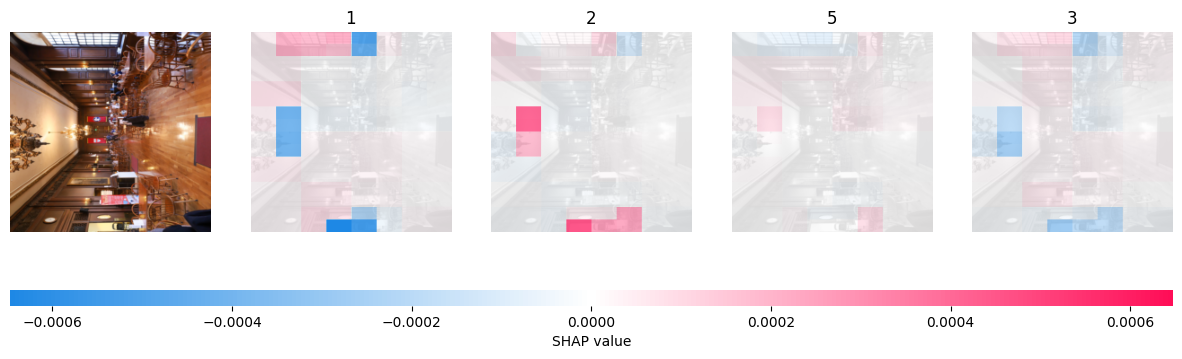

In [45]:
shap.image_plot(shap_values)


### Turning off all ViT Parameters Except the Head.

In [ ]:
for p in vit.parameters():
    p.requires_grad= False

for p in vit.classifier.parameters():
    p.requires_grad = True



## ViT HuggingFace Trainer

In [ ]:
# Setup the training arguments
output_dir = "./pretrainedViT"

# we should edit things like number of training epochs and the batch size
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=100,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    dataloader_num_workers=0,
#     gradient_accumulation_steps=8,
)

In [ ]:
# Compute absolute learning rate
base_learning_rate = 1e-3
total_train_batch_size = (
    training_args.train_batch_size * training_args.gradient_accumulation_steps * training_args.world_size
)

training_args.learning_rate = base_learning_rate * total_train_batch_size / 256
print("Set learning rate to:", training_args.learning_rate)

In [ ]:
# Setup a function to compute accuracy metrics
metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
# Create the trainer
trainer = Trainer(
    model=vit,
    args=training_args,
    train_dataset=image_datasets['train'],
    eval_dataset=image_datasets['val'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()